# Setup

## Create Filesystem
This notebook is primarily meant to be executed in Colab as a computational backend. If you want to run on your own hardware with data, you need to set `data_dir` and `ALLOW_IO`

This notebook viewable directly on Colab from [https://colab.research.google.com/github/rcharan/phutball/blob/rl/pytorch-implementation/model-training.ipynb](https://colab.research.google.com/github/rcharan/phutball/blob/rl/pytorch-implementation/model-training.ipynb) (it is a mirror of github). But if it has moved branches or you are looking at a past commit, look at the [Google instructions](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb) on where to find this file.

The workflow is:
 - Data stored in (my personal/private) Google Drive
 - Utilities/library files (for importing) on github, edited on local hardware and pushed to github.
 - Notebook hosted on github, edited both in Colab or locally (depending on the relative value of having a GPU attached versus being able to use regular Jupyter keyboard shortcuts/a superior interface)

In [1]:
# Attempt Colab setup if on Colab
try:
  import google.colab
except:
  ALLOW_IO = False
else:
  # Mount Google Drive at data_dir
  #  (for data)
  from google.colab import drive
  from os.path import join
  ROOT = '/content/drive'
  DATA = 'My Drive/phutball'
  drive.mount(ROOT)
  ALLOW_IO = True
  data_dir = join(ROOT, DATA)
  !mkdir "{data_dir}"     # in case we haven't created it already   

  # Pull in code from github
  %cd /content
  github_repo = 'https://github.com/rcharan/phutball'
  !git clone -b rl {github_repo}
  %cd /content/phutball
  
  # Point python to code base
  import sys
  sys.path.append('/content/phutball/pytorch-implementation')

  # Updater for library functions changed on local hardware and pushed to github
  #  (circuitous, I know)
  def update_repo():
    !git pull

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
mkdir: cannot create directory ‘/content/drive/My Drive/phutball’: File exists
/content
Cloning into 'phutball'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 1400 (delta 5), reused 14 (delta 5), pack-reused 1382
Receiving objects: 100% (1400/1400), 6.32 MiB | 9.84 MiB/s, done.
Resolving deltas: 100% (833/833), done.
/content/phutball


## Imports

In [0]:
%%capture

%load_ext autoreload
%autoreload 2

import os
import gc
import numpy as np

# Codebase
from lib.model_v1          import TDConway
from lib.moves             import create_placement_getter, get_jumps
from lib.utilities         import config, lfilter
from lib.testing_utilities import create_state, visualize_state, boards
from lib.timer             import Timer
from lib.moves             import END_LOC, COL, CHAIN

# Graphics for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
plt.ioff()

# PyTorch
import torch
from torch.optim import Optimizer

# Tensorflow solely for the Progress Bar (totally worth it)
from tensorflow.keras.utils import Progbar as ProgressBar

## Device Management Utilities
Setup for GPU, CPU, or (not working well/fully implemented) TPU

In [3]:
use_tpu = False

if use_tpu:
  # Install PyTorch/XLA
  !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
  !python pytorch-xla-env-setup.py --version $VERSION
  import torch_xla
  import torch_xla.core.xla_model as xm
  
  # Set the device
  device = xm.xla_device()
  
  # Memory inspection
  def print_memory_usage():
    print('TPU memory inspection not implemented')
  def print_max_memory_usage():
    print('TPU memory inspection not implemented')
  def garbage_collect():
    gc.collect() # No TPU specific implementation yet
    
elif torch.cuda.is_available():
  # Set the device
  device = torch.device('cuda')
  
  # Echo GPU info
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  print(gpu_info)
  
  # Memory inspection and management
  from lib.memory import (
    print_memory_usage_cuda     as print_memory_usage,
    print_max_memory_usage_cuda as print_max_memory_usage,
    garbage_collect_cuda        as garbage_collect
  )

else:
  # Set the device to CPU
  device = torch.device('cpu')
  
  # Echo RAM info
  from psutil import virtual_memory
  from lib.memory import format_bytes
  ram = virtual_memory().total
  print(format_bytes(ram), 'available memory on CPU-based runtime')
  
  # Memory inspection and management
  from lib.memory import (
    print_memory_usage, 
    print_max_memory_usage,
    garbage_collect
  )

Thu May 14 03:31:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    28W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Configuration

In [0]:
BATCH_SIZE = 128
MAX_JUMPS = 300

# PyTorch Tools
These tools will be moved to .py files in the lib folder when stable

## Optimizer

In [0]:
class AlternatingTDLambda(Optimizer):
  '''Implements tracing and updates for the TD(λ) algorithm.
  
  For details see Sutton and Barto, Reinforcement Learning 2ed,
  Chaper 12 Section 2.
  
  Modifications:
    (1) the algorithm is modified to compute traces
        one step early (when the graph is available). Hence, trace must be
        initialized with update_trace before calling step.
        
    (2) Because the board switches sides each turn, eligibility trace updates
        must be of the form z_t+1 <-  -λz_t + 𝝯v
  
  You may find the following greeks a helpful reference:
  alpha : Learning Rate
  lambda: Exponential Decay parameter for the eligibility trace
          (which is essentially momentum but with different
           interpertation and is occasionally zeroed out).
  delta : Temporal difference (TD) i.e. the difference between the estimated
          value of a step and the realized value upon the best move (based
          on further estimation of course).
  '''
  def __init__(self, parameters, alpha, lamda):
    self.alpha = alpha
    self.lamda = lamda # Note alternate spelling (I didn't make it up!)
    defaults   = dict(alpha = alpha, lamda = lamda)

    super(AlternatingTDLambda, self).__init__(parameters, defaults)
    
  @torch.no_grad()
  def step(self, delta, update_trace = True):
    '''Performs a single optimization step updating the trace *afterwards*
    
    update_trace must be called before first step to initialize the trace.
    
    Arguments
    ---------
    
    delta: Difference between estimated value of move at time t and realized
           value after moving and going to time t+1
    '''
    
    for group in self.param_groups:
      alpha = group['alpha']
      
      for p in group['params']:
        if p.grad is None:
          continue
        
        state = self.state[p]
        
        if len(state) == 0 or 'trace' not in state:
          raise RuntimeError('Traces must be initialized before calling step')
          
        trace = state['trace']
        
        p.add_(alpha * delta * trace) # Note gradient *ascent* in reinforcement learning
    
    if update_trace:
      self._update_trace()

  @torch.no_grad()
  def _update_trace(self):
    '''Updates the trace based on the gradients.
    
    This also is the only way to initialize the traces.
    It must be called after evaluating the starting position
    and backprop at the beginning of the game, usually from
    the optimizers restart method.
    '''
    for group in self.param_groups:
      lamda = group['lamda']
      
      for p in group['params']:
        if p.grad is None:
          continue
        
        state = self.state[p]
        
        # Initialize to zero if necessary
        if len(state) == 0 or 'trace' not in state:
          state['trace'] = torch.zeros_like(p)
          
        trace = state['trace']
        trace.mul_(-lamda).add_(p.grad)
      
  @torch.no_grad()
  def _zero_trace(self):
    for group in self.param_groups:
      for p in group['params']:
        state = self.state['p']
        if 'trace' not in state:
          continue
          
        trace = state['trace']
        trace.zero_()
    
  def restart(self, score):
    '''Call to restart the trace
    
    Returns score.item() as a convenience
    '''
    self._zero_trace()
    score.backward()
    self._update_trace()
    self.zero_grad()
    return score.item()

## Training Loop

In [0]:
def training_loop(optimizer, num_games, off_policy = lambda _ : None):
  
  initial_state = create_state('H10').to(device)
  for i in range(num_games):
    print(f'\nPlaying game {i+1} of {num_games}:')
    game_loop(initial_state, model, optimizer, off_policy)

In [0]:
def game_loop(initial_state, model, optimizer, off_policy):
  '''Training loop that plays one game'''
  # Just in case
  optimizer.zero_grad()
  
  # Initialization
  state    = initial_state
  score, _ = model(state.unsqueeze(0))
  v_t      = optimizer.restart(score)
  
  # Progress Bar
  bar      = ProgressBar(284)
  move_num = 1
  
  while True:
    # Determine the next move
    game_over, moved_off_policy, new_state, score = \
      get_next_move_training(state, off_policy = off_policy)
    
    if game_over:      
      delta = 1 - v_t
      optimizer.step(delta, update_trace = False)
      
      # Terminate the progress bar
      bar.target = move_num
      bar.update(move_num)

      break
    
    elif moved_off_policy:
      # Equivalent to starting a new game
      v_t = optimizer.restart(score)
      
    else:
      score.backward()
      delta = (1 - score) - v_t
      optimizer.step(delta)
      optimizer.zero_grad()
      
      v_t   = score.item()
      state = new_state
      
    # Progress bar
    move_num += 1
    if move_num >= bar.target * 0.9:
      bar.target += bar.target // 10 + 1
    
    bar.update(move_num)
    


In [0]:
def get_next_move_training(curr_state, off_policy = lambda _ : None, profile = 0):
  '''Get the next move for the bot
  
  Gets the next move for the bot with computations and
  return value suitable for training only
  (i.e. gradients are taken)
  
  If off_policy is not None, the off_policy move is
  selected instead.
  
  Gradients with respect to the value-function applied
  at the best move are accumlated and availabe to the caller
  
  Inputs
  ------
  
  curr_state: binary tensor of shape (channels, rows, cols)
              reprenting the game state
              
  off_policy: callable with signature
              off_policy(num_available_moves: int) returning
              either None or the index of the move desired.
              If the return value is not None AND the bot 
              cannot otherwise win on that move, then that
              move is made.
              
  profile   : verbosity, will determine whether to time and
              display memory information
              
  Outputs
  -------
  game_over  : boolean. Whether the bot can (and does) win
             on this move. The bot *always* plays a
             win-in-one move when it is available, regardless
             of the off-policy argument.
             
  off_policy : boolean. Whether an off-policy move was made.
             OR: value is None if game is over
  
  new_state  : a binary tensor of same shape as curr_input
             representing the new state of the game after
             the bot moves AND the board is flipped around
             to present it from opponents view. OR: value
             is None if game is over.
               
  value      : value of the value-function applied to new_state.
             OR: value is None if the game is over.
  '''
  # Compute the placements
  placements = get_placements(curr_state)

  # Compute the jumps
  jumps = get_jumps(curr_state, MAX_JUMPS)

  # Deal with special cases/win condition for the jump
  
  # No jumps to worry about
  if len(jumps) == 0:
    moves = placements
  
  # Win condition
  elif (
    len(jumps) == 1 and
    jumps[0][CHAIN][END_LOC][COL] in [config.cols, config.cols-1]):
    return True, None, None, None # The game is over!
  
  # Regular jump evaluation
  else:
    # Retain only the final state
    jumps = [jump_data[0] for jump_data in jumps]
    jumps = torch.tensor(jumps, dtype = torch.bool, device = device)
    moves = torch.cat([placements, jumps])
    
  # Turn the board around to represent the opponent's view
  moves = torch.flip(moves, [-1])
  
  # Either make an off policy move, or evaluate the value-function
  #  to determine the policy
  off_policy_move = off_policy(moves.shape[0])
  if off_policy_move is not None:
    move     = moves[off_policy_move].unsqueeze(0)
    score, _ = model(move)
    return False, True, move, score
  
  # Batch the moves
  batches = torch.split(moves, BATCH_SIZE)
  
  # We only need to differentiate the best score
  #  track which one that is.
  best_score = None
  best_index = None
  curr_index = 0

  if profile:
    timer = Timer()
    print(f'Starting forward pass')
    print_memory_usage()
    batch_num = 0
    
  for batch in batches:

    
    # Run the model
    score, index = model(batch)

    # Update running tally of best score
    #  Old best scores should have their graphs
    #  destroyed

    if best_score is None or score > best_score:
      best_score = score
      best_index = curr_index + index

    # Keep track of how many indices we've traversed to 
    #  get best_index correct
    curr_index += batch.shape[0]
    
    
    if profile:
      print('')
      batch_num += 1
      print(f'Completed batch {batch_num} after a total of {timer}')
      if profile > 1:
        print_memory_usage()

  if profile > 1:
    print_max_memory_usage()
  
  # Return
  return False, False, moves[best_index], best_score

# Off-policy policy

In [0]:
class EpsilonGreedy:
  
  def __init__(self, epsilon):
    self.epsilon = epsilon
  
  def __call__(self, num_options):
    if np.random.random() < self.epsilon:
      return np.random.randint(0, num_options)
    else:
      return None

# Execution

## Instantiate

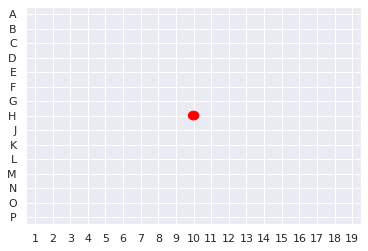

In [80]:
get_placements = create_placement_getter(device)
epsilon_greedy = EpsilonGreedy(0.1)

model = TDConway(config).to(device)
optimizer = AlternatingTDLambda(model.parameters(), 0.01, 0.9)

initial_state = create_state('H10').to(device)
visualize_state(initial_state)

## Profile

In [78]:
# # Blazing fast on a P100!
# %%prun
# get_next_move_training(initial_state);
# _ = _

In [77]:
# # Decently fast. A pace of 10000 games per day
# %%prun
# training_loop(optimizer, 1, off_policy = epsilon_greedy)


Playing game 1 of 1:
152/152 [==============================] - 13s 84ms/step
 

## Run!

In [81]:
training_loop(optimizer, 100, off_policy = epsilon_greedy)


Playing game 1 of 100:
128/128 [==============================] - 11s 86ms/step

Playing game 2 of 100:
59/59 [==============================] - 5s 85ms/step

Playing game 3 of 100:
74/74 [==============================] - 6s 81ms/step

Playing game 4 of 100:
125/125 [==============================] - 11s 87ms/step

Playing game 5 of 100:
88/88 [==============================] - 8s 92ms/step

Playing game 6 of 100:
134/134 [==============================] - 12s 86ms/step

Playing game 7 of 100:
86/86 [==============================] - 8s 89ms/step

Playing game 8 of 100:
187/187 [==============================] - 15s 79ms/step

Playing game 9 of 100:
225/225 [==============================] - 18s 79ms/step

Playing game 10 of 100:
74/74 [==============================] - 7s 93ms/step

Playing game 11 of 100:
83/83 [==============================] - 8s 91ms/step

Playing game 12 of 100:
94/94 [==============================] - 8s 89ms/step

Playing game 13 of 100:
69/69 [==============

IndexError: ignored

In [0]:
def save(fname, model, optimizer):
  state_dict = {
      'model' : model.state_dict(),
      'optim' : optimizer.state_dict()
  }
  torch.save(state_dict, f'{data_dir}/{fname}.pt')

In [0]:
# save('v0.1.1-31', model, optimizer)